In [1]:
import pathlib as pl
import numpy as np
import modflowapi
import swiapi
import flopy

# path to mf6 shared library
# executables based on mf6 feat-swi branch at: 
#   https://github.com/langevin-usgs/modflow6/tree/feat-swi
mf6exe = "/Users/jdhughes/Documents/Work/SWI6/modflow6/bin/mf6"
libmf6 = "/Users/jdhughes/Documents/Work/SWI6/modflow6/bin/libmf6.dylib"


## MODFLOW-USG results for problem

In [2]:
hds_usg = np.array(
      [0.2       , 0.59686235, 0.76508142, 0.89446596, 1.00096258,
       1.0914691 , 1.16976336, 1.23818961, 1.29832132, 1.35127281,
       1.397864  , 1.43871521, 1.47430508, 1.50500784, 1.53111814,
       1.55286808, 1.57043912, 1.58397057, 1.59356545, 1.59929471,
       1.60119991, 1.59929471, 1.59356545, 1.58397057, 1.57043912,
       1.55286808, 1.53111814, 1.50500784, 1.47430508, 1.43871521,
       1.397864  , 1.35127281, 1.29832132, 1.23818961, 1.16976336,
       1.0914691 , 1.00096258, 0.89446596, 0.76508142, 0.59686235,
       0.2       ]
                  )

In [3]:
zeta_usg = np.array(
    [ -8.        , -23.87449386, -30.60325662, -35.77863827,
       -40.03850338, -43.65876407, -46.79053437, -49.52758447,
       -51.93285291, -54.05091221, -55.91456001, -57.5486084 ,
       -58.97220318, -60.20031357, -61.24472552, -62.11472301,
       -62.81756499, -63.35882268, -63.74261796, -63.97178855,
       -64.04799631, -63.97178855, -63.74261796, -63.35882268,
       -62.81756499, -62.11472301, -61.24472552, -60.20031357,
       -58.97220318, -57.5486084 , -55.91456001, -54.05091221,
       -51.93285291, -49.52758447, -46.79053437, -43.65876407,
       -40.03850338, -35.77863827, -30.60325662, -23.87449386,
        -8.        ]
)

In [4]:
hds_usg.shape

(41,)

## Create and Run Simple Test Model

In [5]:
#create simple test model
Lx = 2050.0 # meters
ncol = 41
nlay = 1
nrow = 1
delr, delc = Lx / ncol, 1.0
top = 5.
botm = -80.
recharge = 1e-3
k = 10.
h0 = 0.2
h1 = h0
icelltype = 1
max_outer = 50
newton_option = None #"newton"
if newton_option is None:
    linear_accel = "cg"
else:
    linear_accel = "bicgstab"

name = "usg"
ws = pl.Path(f"temp/{name}")
sim = flopy.mf6.MFSimulation(
    sim_name=name, 
    sim_ws=ws, 
    exe_name=mf6exe,
    memory_print_option="all"
)
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(sim, outer_dvclose=1e-8, inner_dvclose=1e-9, linear_acceleration=linear_accel, outer_maximum=max_outer)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True, newtonoptions=newton_option)
dis = flopy.mf6.ModflowGwfdis(
    gwf, 
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)
ic = flopy.mf6.ModflowGwfic(gwf)
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    save_specific_discharge=True,
    save_saturation=True,
    # alternative_cell_averaging="AMT-HMK",
    icelltype=icelltype,
    k=k,
)
swi = flopy.mf6.ModflowGwfswi(gwf, zeta=botm)
chd_spd = [
    ((0, 0, 0), h0),
    ((0, 0, ncol - 1), h1),
]
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chd_spd)
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=recharge)
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(
        gwf,
        budget_filerecord=budget_file,
        head_filerecord=head_file,
        saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
        printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
)
sim.write_simulation()
#sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model usg...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package swi...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 2 based on size of stress_period_data
    writing package rcha_0...
    writing package oc...


## Run Example Using API

### Run Model by Iteration

In [6]:
mf6_swi = swiapi.SwiAPI(libmf6, ws, name)
mf6_swi.run(maxiter=max_outer)

Initializing mf6...
Accessing pointer using tag: TDIS/DELT
Accessing pointer using tag: TDIS/NPER
Accessing pointer using tag: USG/INSTO
Accessing pointer using tag: USG/ISS
Accessing pointer using tag: USG/X
Accessing pointer using tag: USG/XOLD
Accessing pointer using tag: USG/RHS
Accessing pointer using tag: SLN_1/IA
Accessing pointer using tag: SLN_1/JA
Accessing pointer using tag: SLN_1/AMAT
Accessing pointer using tag: USG/DIS/AREA
Accessing pointer using tag: USG/DIS/TOP
Accessing pointer using tag: USG/DIS/BOT
Accessing pointer using tag: USG/NPF/SAT
Accessing pointer using tag: USG/NPF/CONDSAT
Accessing pointer using tag: USG/NPF/DERV_MULT
Accessing pointer using tag: USG/SWI/ZETA
Accessing pointer using tag: USG/SWI/HCOF
Accessing pointer using tag: USG/SWI/RHS
Simulation end time = 1.0...

  Solving for time 0.0
  Prepare time step with dt=[0.]...
  Prepare solve...
    Solve...(kiter=0)
    Solve...(kiter=1)
    Solve...(kiter=2)
    Solve...(kiter=3)
    Solve...(kiter=4)


/Users/jdhughes/miniforge3/envs/develop/lib/python3.11/site-packages/xmipy/xmiwrapper.py:624: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c_dt = c_double(dt)


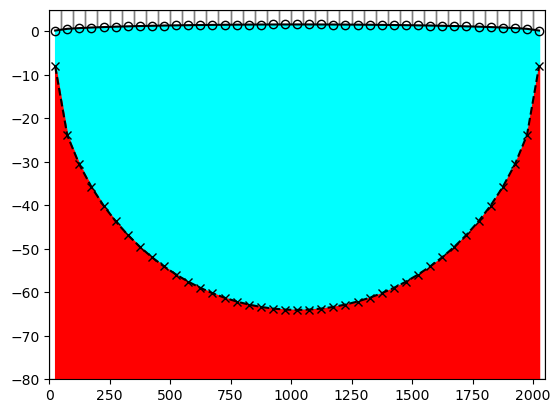

In [7]:
zeta = mf6_swi.zeta_last
x = gwf.modelgrid.xcellcenters.flatten()
head = gwf.output.head().get_data().flatten()
bud = gwf.output.budget()
#print(head.flatten())
#print(zeta.flatten())

spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
pxs = flopy.plot.PlotCrossSection(gwf, line={"row":0})
ax = pxs.ax
if ncol < 50:
    pxs.plot_grid()
#pxs.plot_bc("ghb")
ax.plot(x, head, "k-")
ax.plot(x, zeta, "k--")
# freshwater
ax.fill_between(x, head, zeta, color="cyan")
# saltwater
ax.fill_between(x, zeta, botm, color="red")
# pxs.plot_vector(qx, qy, qz, normalize=True, color="black")

ax.plot(x, hds_usg, lw=0, mec="black", mfc="none", marker="o")
ax.plot(x, zeta_usg, lw=0, mec="black", mfc="none", marker="x");


In [8]:
fpth = pl.Path(ws) / f"{name}.dis.grb"
grb = flopy.mf6.utils.MfGrdFile(fpth)
ia = grb.ia
ja = grb.ja
nodes = grb.nodes
flowja = bud.get_data(text="FLOW-JA-FACE")[0].flatten()

# print flows bewteen cells
# for n in range(nodes):
#     for ipos in range(ia[n] + 1, ia[n + 1]):
#         m = ja[ipos]
#         q = flowja[ipos]
#         if m > n:
#             print(f"{n=} {m=} {q=}")

In [9]:
bobj = gwf.output.budget()

In [10]:
bobj.get_unique_record_names()

[b'    FLOW-JA-FACE',
 b'      DATA-SPDIS',
 b'        DATA-SAT',
 b'            RCHA',
 b'             CHD',
 b'         STORAGE']

In [11]:
bobj.get_data(text="DATA-SAT")

[rec.array([( 1,  1, 0., 0.09647059), ( 2,  2, 0., 0.28789831),
            ( 3,  3, 0., 0.36903927), ( 4,  4, 0., 0.43144829),
            ( 5,  5, 0., 0.48281725), ( 6,  6, 0., 0.52647333),
            ( 7,  7, 0., 0.5642388 ), ( 8,  8, 0., 0.5972444 ),
            ( 9,  9, 0., 0.62624911), (10, 10, 0., 0.65179041),
            (11, 11, 0., 0.67426381), (12, 12, 0., 0.69396851),
            (13, 13, 0., 0.71113539), (14, 14, 0., 0.72594496),
            (15, 15, 0., 0.73853934), (16, 16, 0., 0.74903048),
            (17, 17, 0., 0.75750593), (18, 18, 0., 0.76403286),
            (19, 19, 0., 0.76866098), (20, 20, 0., 0.77142451),
            (21, 21, 0., 0.77234349), (22, 22, 0., 0.77142451),
            (23, 23, 0., 0.76866098), (24, 24, 0., 0.76403286),
            (25, 25, 0., 0.75750593), (26, 26, 0., 0.74903048),
            (27, 27, 0., 0.73853934), (28, 28, 0., 0.72594496),
            (29, 29, 0., 0.71113539), (30, 30, 0., 0.69396851),
            (31, 31, 0., 0.67426381), (3

In [12]:
-head * 40.

array([ -8.        , -23.87449386, -30.60325662, -35.77863827,
       -40.03850339, -43.65876407, -46.79053438, -49.52758448,
       -51.93285293, -54.05091224, -55.91456005, -57.54860844,
       -58.97220322, -60.20031362, -61.24472557, -62.11472307,
       -62.81756505, -63.35882274, -63.74261802, -63.97178862,
       -64.04799638, -63.97178862, -63.74261802, -63.35882274,
       -62.81756505, -62.11472307, -61.24472557, -60.20031362,
       -58.97220322, -57.54860844, -55.91456005, -54.05091224,
       -51.93285293, -49.52758448, -46.79053438, -43.65876407,
       -40.03850339, -35.77863827, -30.60325662, -23.87449386,
        -8.        ])

In [13]:
zeta

array([ -8.        , -23.87449386, -30.60325662, -35.77863827,
       -40.03850339, -43.65876407, -46.79053438, -49.52758449,
       -51.93285293, -54.05091224, -55.91456005, -57.54860844,
       -58.97220322, -60.20031362, -61.24472557, -62.11472307,
       -62.81756506, -63.35882275, -63.74261802, -63.97178862,
       -64.04799638, -63.97178862, -63.74261802, -63.35882275,
       -62.81756506, -62.11472307, -61.24472557, -60.20031362,
       -58.97220322, -57.54860844, -55.91456005, -54.05091224,
       -51.93285293, -49.52758449, -46.79053438, -43.65876407,
       -40.03850339, -35.77863827, -30.60325662, -23.87449386,
        -8.        ])

In [14]:
(-head * 40.) - zeta

array([0.00000000e+00, 5.80868686e-12, 2.67732503e-11, 6.88800128e-11,
       1.35450762e-10, 2.27551311e-10, 3.44321904e-10, 4.83382223e-10,
       6.41186659e-10, 8.13273004e-10, 9.94660354e-10, 1.17998411e-09,
       1.36376599e-09, 1.54064139e-09, 1.70551573e-09, 1.85367810e-09,
       1.98094341e-09, 2.08374473e-09, 2.15926832e-09, 2.20543228e-09,
       2.22095764e-09, 2.20543228e-09, 2.15926832e-09, 2.08374473e-09,
       1.98093630e-09, 1.85367810e-09, 1.70552283e-09, 1.54064850e-09,
       1.36376599e-09, 1.17998411e-09, 9.94674565e-10, 8.13287215e-10,
       6.41186659e-10, 4.83389329e-10, 3.44329010e-10, 2.27558417e-10,
       1.35457867e-10, 6.88800128e-11, 2.67768030e-11, 5.81223958e-12,
       0.00000000e+00])

In [15]:
head.max()

1.6011999095644491

In [16]:
head - hds_usg

array([ 0.00000000e+00, -3.43182327e-09, -4.49354842e-09, -3.23329175e-09,
        4.66691685e-09,  1.84588744e-09, -4.86942930e-10,  2.11542073e-09,
        3.35457107e-09, -4.10143031e-09,  1.13114473e-09,  9.85441284e-10,
        5.59342794e-10,  5.34739586e-10, -8.13926038e-10, -3.32462768e-09,
        6.36154396e-09, -1.40723344e-09,  5.69853498e-10,  5.55698532e-09,
       -4.35550929e-10,  5.55698509e-09,  5.69853054e-10, -1.40723388e-09,
        6.36154374e-09, -3.32462835e-09, -8.13926482e-10,  5.34739364e-10,
        5.59342794e-10,  9.85441950e-10,  1.13114518e-09, -4.10142964e-09,
        3.35457129e-09,  2.11542051e-09, -4.86942708e-10,  1.84588766e-09,
        4.66691752e-09, -3.23329119e-09, -4.49354776e-09, -3.43182249e-09,
        0.00000000e+00])